In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

#Used for month, day_of_week, hour_of_day, weekday and holiday

data = pd.read_csv("../Training/training_data_VT2026.csv")

# Make buinary variable for high bike demand:
# high_bike_demand -> 1
# low_bike_demand  -> 0
data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)


# Share of high demand
weekday_high_rate = data.groupby("precip")["high_demand"].mean()


plt.figure(figsize=(10, 5))
plt.bar(weekday_high_rate.index, weekday_high_rate.values)

plt.xlabel("Weekday )")
plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand depending on weekday or weekend")

plt.ylim(0, 1)
plt.xticks(range(0, 2))
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("demand_over_weekday.png", bbox_inches="tight", pad_inches=0)
plt.show()

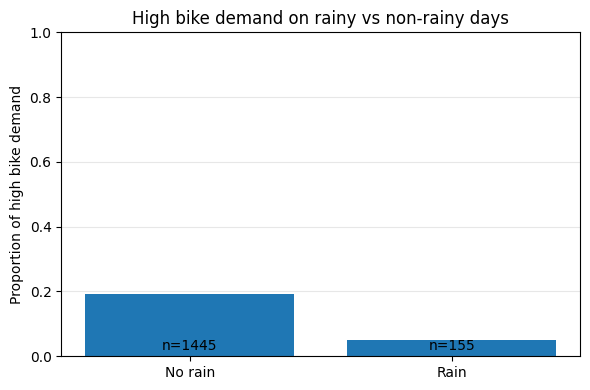

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)

# Binary rain-variable
data["rain"] = (data["precip"] > 0).astype(int)

summary = (
    data.groupby("rain")
    .agg(
        high_rate=("high_demand", "mean"),
        count=("high_demand", "size")
    )
)

plt.figure(figsize=(6, 4))
plt.bar(["No rain", "Rain"], summary["high_rate"])

plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand on rainy vs non-rainy days")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

for i, n in enumerate(summary["count"]):
    plt.text(i, 0.02, f"n={n}", ha="center", fontsize=10)

plt.tight_layout()
plt.savefig("precip.png", bbox_inches="tight", pad_inches=0)
plt.show()


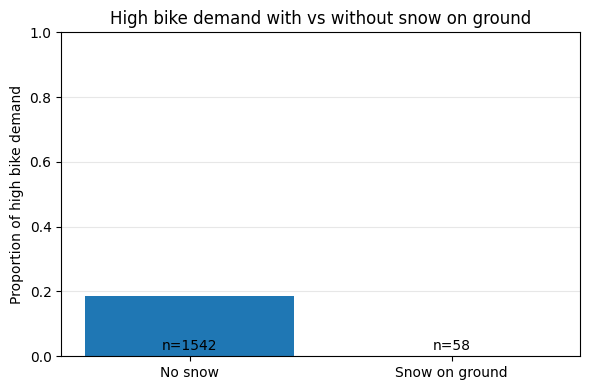

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("../Training/training_data_VT2026.csv")
data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)

# Binär snow-variable
data["snow_on_ground"] = (data["snowdepth"] > 0).astype(int)

summary = (
    data.groupby("snow_on_ground")
    .agg(
        high_rate=("high_demand", "mean"),
        count=("high_demand", "size")
    )
)

plt.figure(figsize=(6, 4))
plt.bar(["No snow", "Snow on ground"], summary["high_rate"])

plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand with vs without snow on ground")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

for i, n in enumerate(summary["count"]):
    plt.text(i, 0.02, f"n={n}", ha="center", fontsize=10)

plt.tight_layout()
plt.savefig("snow_on_ground.png", bbox_inches="tight", pad_inches=0)
plt.show()


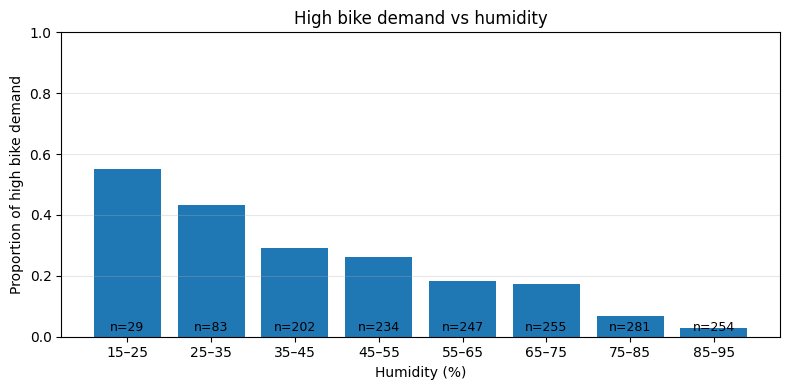

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv("../Training/training_data_VT2026.csv")
data["high_demand"] = (data["increase_stock"] == "high_bike_demand").astype(int)

# Define even bins for humidity
bins = np.arange(15, 100, 10)  # 15–95 i steg om 10
data["humidity_bin"] = pd.cut(data["humidity"], bins=bins)

summary = (
    data.groupby("humidity_bin")
    .agg(
        high_rate=("high_demand", "mean"),
        count=("high_demand", "size")
    )
)

plt.figure(figsize=(8, 4))
plt.bar(range(len(summary)), summary["high_rate"])

plt.xticks(
    range(len(summary)),
    [f"{int(b.left)}–{int(b.right)}" for b in summary.index],
)

plt.xlabel("Humidity (%)")
plt.ylabel("Proportion of high bike demand")
plt.title("High bike demand vs humidity")
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)

# Add count of observations above bars
for i, n in enumerate(summary["count"]):
    plt.text(i, 0.02, f"n={n}", ha="center", fontsize=9)

plt.tight_layout()
plt.savefig("humidity.png", bbox_inches="tight", pad_inches=0)
plt.show()


Peak runt 17-18 på kvällen!

Peak på lördagar! (och lite söndagar)

Peak Juni, april, september (oktober)

Inte jättestor skillnad på holiday eller ej

Större efterfrågan på helger!